In [40]:
import tsplib95
import torch
import time
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import torch.optim as optim

In [41]:
class StandardAntColonyOptimizer:
    def __init__(self, num_nodes, distance_matrix, num_ants=10, alpha=1.0, beta=2.0, evaporation_rate=0.5, Q=100):
        self.num_nodes = num_nodes
        self.distance_matrix = distance_matrix
        self.pheromone = np.ones((num_nodes, num_nodes))
        self.num_ants = num_ants
        self.alpha = alpha  # Pheromone importance
        self.beta = beta    # Heuristic importance
        self.evaporation_rate = evaporation_rate
        self.Q = Q  # Pheromone deposit factor
        self.best_distances_per_iteration = []  # Store best distances per iteration for comparison

    def optimize(self, iterations):
        best_distance = float('inf')
        best_solution = None
        for iteration in range(iterations):
            solutions = []
            distances = []
            for ant in range(self.num_ants):
                solution = self.construct_solution()  # Create solution for each ant
                distance = self.calculate_total_distance(solution)
                solutions.append(solution)
                distances.append(distance)
                if distance < best_distance:
                    best_distance = distance
                    best_solution = solution
            self.update_pheromone(solutions, distances)
            self.best_distances_per_iteration.append(best_distance)  
            print(f"Iteration {iteration+1}/{iterations}, Best Distance: {best_distance:.4f}")
        return best_solution, best_distance

    def construct_solution(self):
        solution = []
        visited = set()
        current_node = np.random.randint(0, self.num_nodes) 
        solution.append(current_node)
        visited.add(current_node)
        while len(visited) < self.num_nodes:  # Continue until all nodes are visited
            probabilities = self.calculate_transition_probabilities(current_node, visited)
            next_node = np.random.choice(range(self.num_nodes), p=probabilities)
            solution.append(next_node)
            visited.add(next_node)
            current_node = next_node
        return solution

    def calculate_transition_probabilities(self, current_node, visited):
        pheromone = self.pheromone[current_node]
        heuristic = 1 / (self.distance_matrix[current_node] + 1e-6)  # Add a small value to avoid division by zero
        heuristic[heuristic == np.inf] = 0  # In case of infinite distance, set heuristic to 0

        # Calculate probabilities by combining pheromone and heuristic values
        combined = (pheromone ** self.alpha) * (heuristic ** self.beta)
        for node in visited:
            combined[node] = 0  # Set probability of visited nodes to 0

        total = np.sum(combined)
        if total == 0:
            probabilities = np.ones(self.num_nodes)
            probabilities[list(visited)] = 0
            probabilities /= np.sum(probabilities)
        else:
            probabilities = combined / total
        return probabilities

    def update_pheromone(self, solutions, distances):
        self.pheromone *= (1 - self.evaporation_rate)  # Evaporation step
        for solution, distance in zip(solutions, distances):
            pheromone_contribution = self.Q / distance  # Higher pheromone contribution for better solutions
            for i in range(len(solution) - 1):
                from_node = solution[i]
                to_node = solution[i + 1]
                self.pheromone[from_node][to_node] += pheromone_contribution
            # Complete the tour (return to the start)
            self.pheromone[solution[-1]][solution[0]] += pheromone_contribution

    def calculate_total_distance(self, solution):
        distance = 0
        for i in range(len(solution) - 1):
            distance += self.distance_matrix[solution[i]][solution[i + 1]]
        distance += self.distance_matrix[solution[-1]][solution[0]]  # Return to the starting node
        return distance

In [37]:
def getData(technique, problem):
    start = time.time()
    
    # runs the  problem with the technique 
    result = technique(problem.edge_matrix)
    end = time.time()
    
    # gets the solution
    returned_solution = result['sequence']
    
    #the time 
    runtime = end-start
    
    # memory
    """TODO: Check that memory actually works"""
    memory = torch.cuda.memory_allocated(0)
    print(memory)
    
    #function evalauations 
    func_evals = result['func_evals']
    
    #used parameters
    params = result['parameters']

    #find proximity to optimal solution
    """TODO: implement closeness function"""
    closeness = torch.subtract(returned_solution, problem.solution)
    closeness=torch.sum(torch.abs(closeness)).numpy()

    return {'memory' : memory, 'closeness' : closeness, 'func_evals' : func_evals, 'runtime' : runtime}

In [35]:
def generatePlots(results):
    fig, ax = plt.subplots(nrows=1, ncols=3)

    ax[0].scatter(results['memory'], results['closeness'])
    ax[0].set_title('Memory vs. Performance')
    ax[0].set_ylabel('Performance')
    ax[0].set_xlabel('Memory')
    
    ax[1].scatter(results['func_evals'], results['closeness'])
    ax[1].set_title('Distance Checks vs. Performance')
    ax[1].set_ylabel('Performance')
    ax[1].set_xlabel('Distance Checks')
    
    ax[2].scatter(results['runtime'], results['closeness'])
    ax[2].set_title('Runtime vs. Performance')
    ax[2].set_ylabel('Performance')
    ax[2].set_xlabel('Runtime')

    fig.suptitle('Stacked subplots in one direction')

0


IndexError: list assignment index out of range

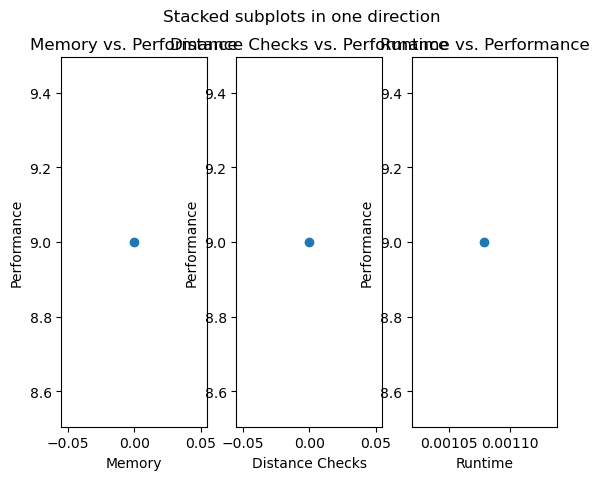

<Figure size 1000x700 with 0 Axes>

In [39]:
#collect techniques in an array
techniques = [sortedTechnique]

#collect problems in an array
problems = [p1]

# run each function on many problems to compare results
for t in techniques:
    figs = []
    # run each problem on the technique
    
    for p in problems:
        #take data and add to list for plotting purposes
        results = {'memory' : [], 'runtime': [], 'func_evals': [], 'closeness': []}
        r = getData(t,p)
        results['memory'].append(r['memory'])
        results['func_evals'].append(r['func_evals'])
        results['runtime'].append(r['runtime'])
        results['closeness'].append(r['closeness'])
        
    #for each function, generate a subfigure with each plot
    figs.append(generatePlots(results))

fig = plt.figure(figsize=(10, 7))
(figs[0], figs[1], figs[2]) = fig.subfigures(3, 1)
plt.show()

In [20]:
def sortedTechnique(e_matrix):
    res = torch.tensor(range(e_matrix.shape[0]+1))
    func_evals = 0
    params = {}
    return {'func_evals': func_evals, 'sequence': res, 'parameters':params}

In [11]:
class Problem:
    
    def __init__(self, edge_weights, solution):
        self.edge_matrix = edge_weights
        self.solution = solution


weights = torch.tensor([[0, 10,15,20],
                         [10,0,35,25],
                         [15,35,0,30],
                         [20,25,30,0]
                         ])
soln = torch.tensor([1,2,4,3,-1])

p1 = Problem(weights, soln)